In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, precision_recall_fscore_support,
                             roc_curve, auc, roc_auc_score)
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
df = pd.read_csv('../clean_dbt_district_wise.csv')

# Filter for latest year
df_2023 = df[df['fy'] == '2023-2024'].copy()

print("="*80)
print("DBT DISTRICT-WISE CLASSIFICATION ANALYSIS")
print("="*80)
print(f"\nDataset Shape: {df_2023.shape}")
print(f"Number of Districts: {df_2023['district_name'].nunique()}")
print(f"Number of States: {df_2023['state_name'].nunique()}")


DBT DISTRICT-WISE CLASSIFICATION ANALYSIS

Dataset Shape: (765, 9)
Number of Districts: 760
Number of States: 36


In [3]:
# ============================================================================
# CREATE TARGET VARIABLE - DISTRICT PERFORMANCE CATEGORIES
# ============================================================================
print("\n" + "="*80)
print("CREATING TARGET VARIABLE: DISTRICT PERFORMANCE CATEGORIES")
print("="*80)

# Create meaningful categories based on transfer efficiency
df_2023['total_transfer_billions'] = df_2023['total_dbt_transfer'] / 1e9
df_2023['transactions_millions'] = df_2023['no_of_dbt_transactions'] / 1e6

# Define performance categories based on multiple criteria
def categorize_district(row):
    transfer = row['total_transfer_billions']
    transactions = row['transactions_millions']
    per_txn = row['transfer_per_transaction']
    
    # High performer: High transfer, high transactions, efficient per transaction
    if transfer > df_2023['total_transfer_billions'].quantile(0.75) and \
       transactions > df_2023['transactions_millions'].quantile(0.75):
        return 'High Performer'
    
    # Low performer: Low transfer, low transactions
    elif transfer < df_2023['total_transfer_billions'].quantile(0.25) and \
         transactions < df_2023['transactions_millions'].quantile(0.25):
        return 'Low Performer'
    
    # High efficiency: Moderate-to-high transfer per transaction
    elif per_txn > df_2023['transfer_per_transaction'].quantile(0.75):
        return 'High Efficiency'
    
    # Everything else is moderate
    else:
        return 'Moderate Performer'

df_2023['performance_category'] = df_2023.apply(categorize_district, axis=1)

# Display category distribution
print("\nPerformance Category Distribution:")
print(df_2023['performance_category'].value_counts())
print("\nCategory Percentages:")
print(df_2023['performance_category'].value_counts(normalize=True) * 100)


CREATING TARGET VARIABLE: DISTRICT PERFORMANCE CATEGORIES

Performance Category Distribution:
performance_category
Moderate Performer    365
Low Performer         145
High Efficiency       139
High Performer        116
Name: count, dtype: int64

Category Percentages:
performance_category
Moderate Performer    47.712418
Low Performer         18.954248
High Efficiency       18.169935
High Performer        15.163399
Name: proportion, dtype: float64


In [4]:
# ============================================================================
# FEATURE ENGINEERING
# ============================================================================
print("\n" + "="*80)
print("FEATURE ENGINEERING")
print("="*80)

# Select and engineer features
features_to_use = [
    'total_dbt_transfer',
    'no_of_dbt_transactions',
    'transfer_per_transaction'
]

X = df_2023[features_to_use].copy()
y = df_2023['performance_category'].copy()

# Handle missing values in features
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')
    X[col].fillna(X[col].median(), inplace=True)

# Handle outliers in features
for col in X.columns:
    Q1, Q3 = X[col].quantile(0.25), X[col].quantile(0.75)
    IQR = Q3 - Q1
    X[col] = X[col].clip(lower=Q1 - 1.5 * IQR, upper=Q3 + 1.5 * IQR)

# Handle infinite values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"\nFeatures used: {features_to_use}")
print(f"Target classes: {le.classes_}")
print(f"\nFeature Statistics:")
print(X.describe())

# Verify no NaN values remain
print("\nNaN values in features:")
print(X.isnull().sum())


FEATURE ENGINEERING

Features used: ['total_dbt_transfer', 'no_of_dbt_transactions', 'transfer_per_transaction']
Target classes: ['High Efficiency' 'High Performer' 'Low Performer' 'Moderate Performer']

Feature Statistics:
       total_dbt_transfer  no_of_dbt_transactions  transfer_per_transaction
count        7.650000e+02            7.650000e+02                765.000000
mean         1.264174e+09            8.776505e+05               1723.569340
std          1.025165e+09            7.405713e+05               1079.321470
min          0.000000e+00            0.000000e+00                 76.244040
25%          4.401924e+08            3.064870e+05                921.013645
50%          1.056801e+09            6.844210e+05               1536.534750
75%          1.817821e+09            1.223958e+06               2278.694022
max          3.884264e+09            2.600164e+06               4315.214589

NaN values in features:
total_dbt_transfer          0
no_of_dbt_transactions      0
transf

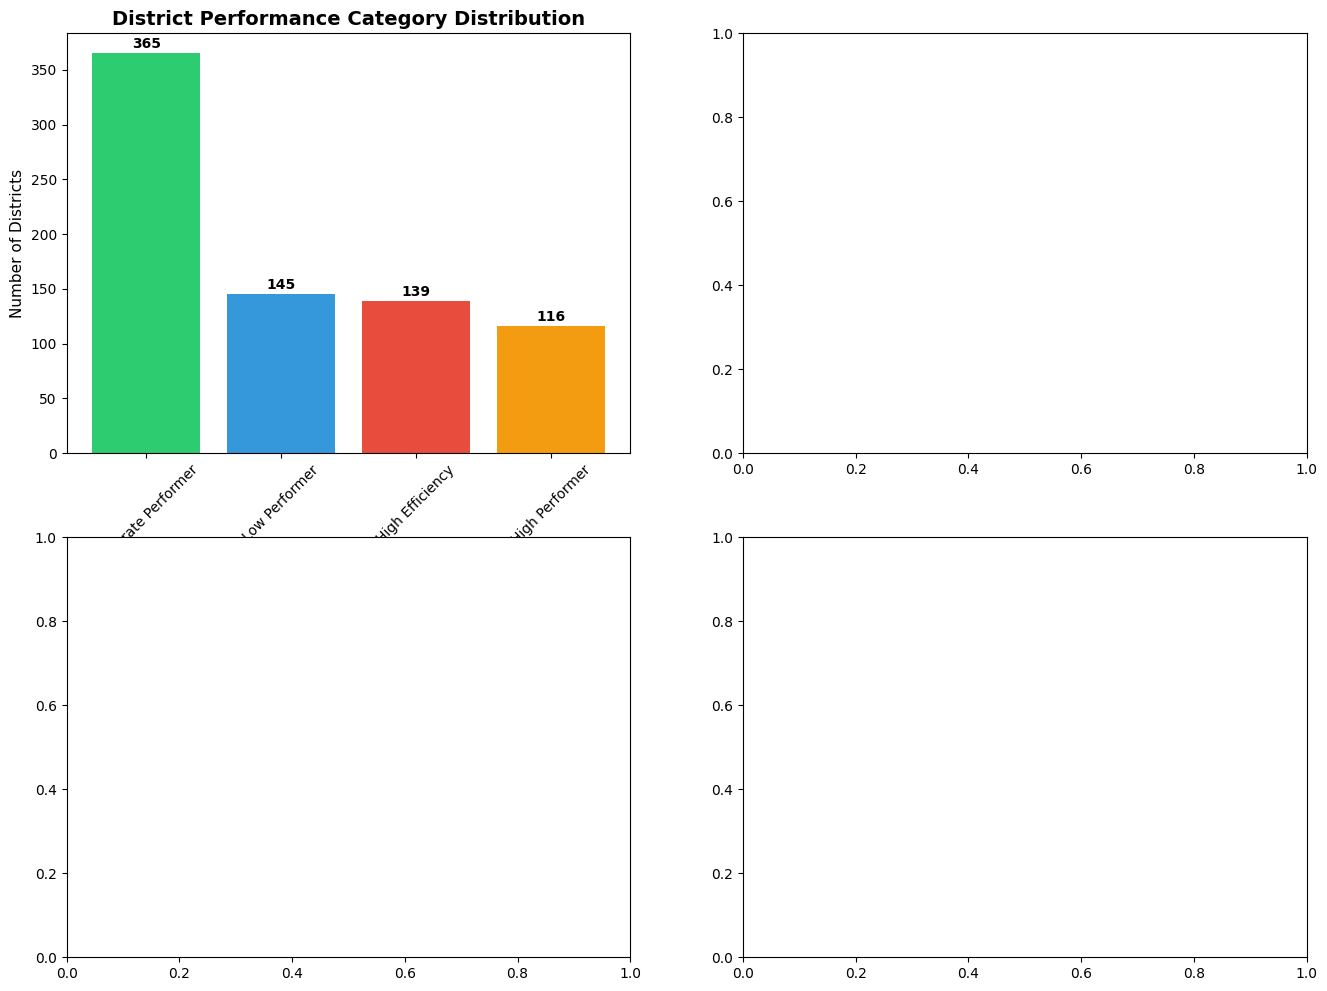

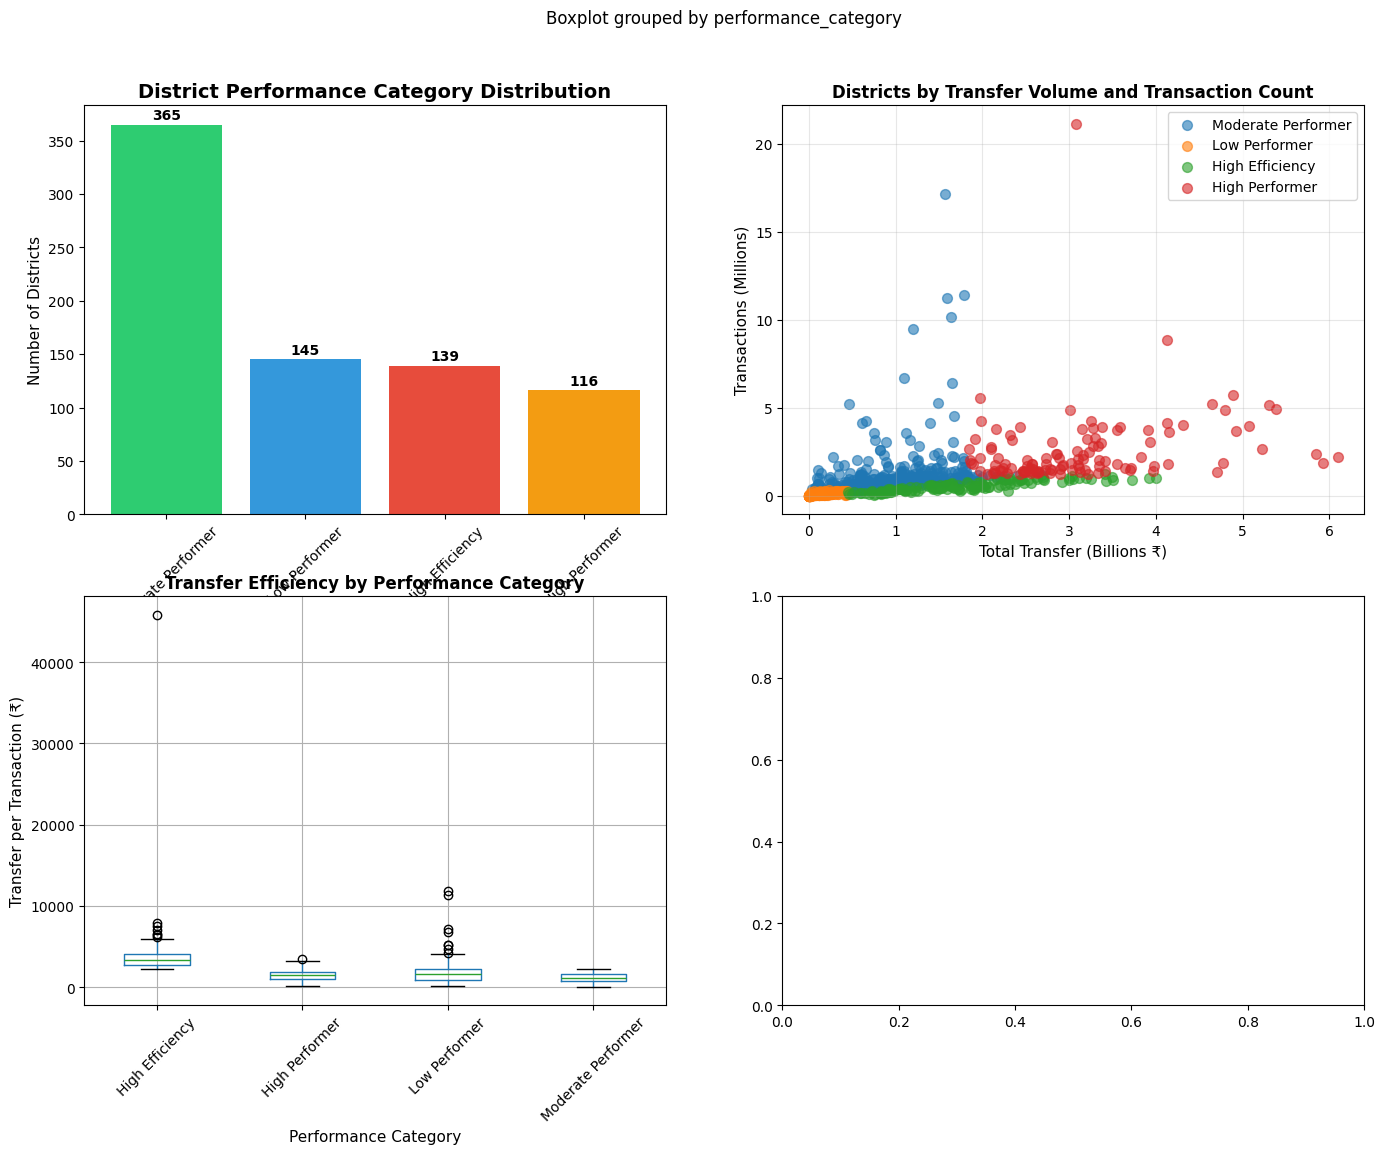

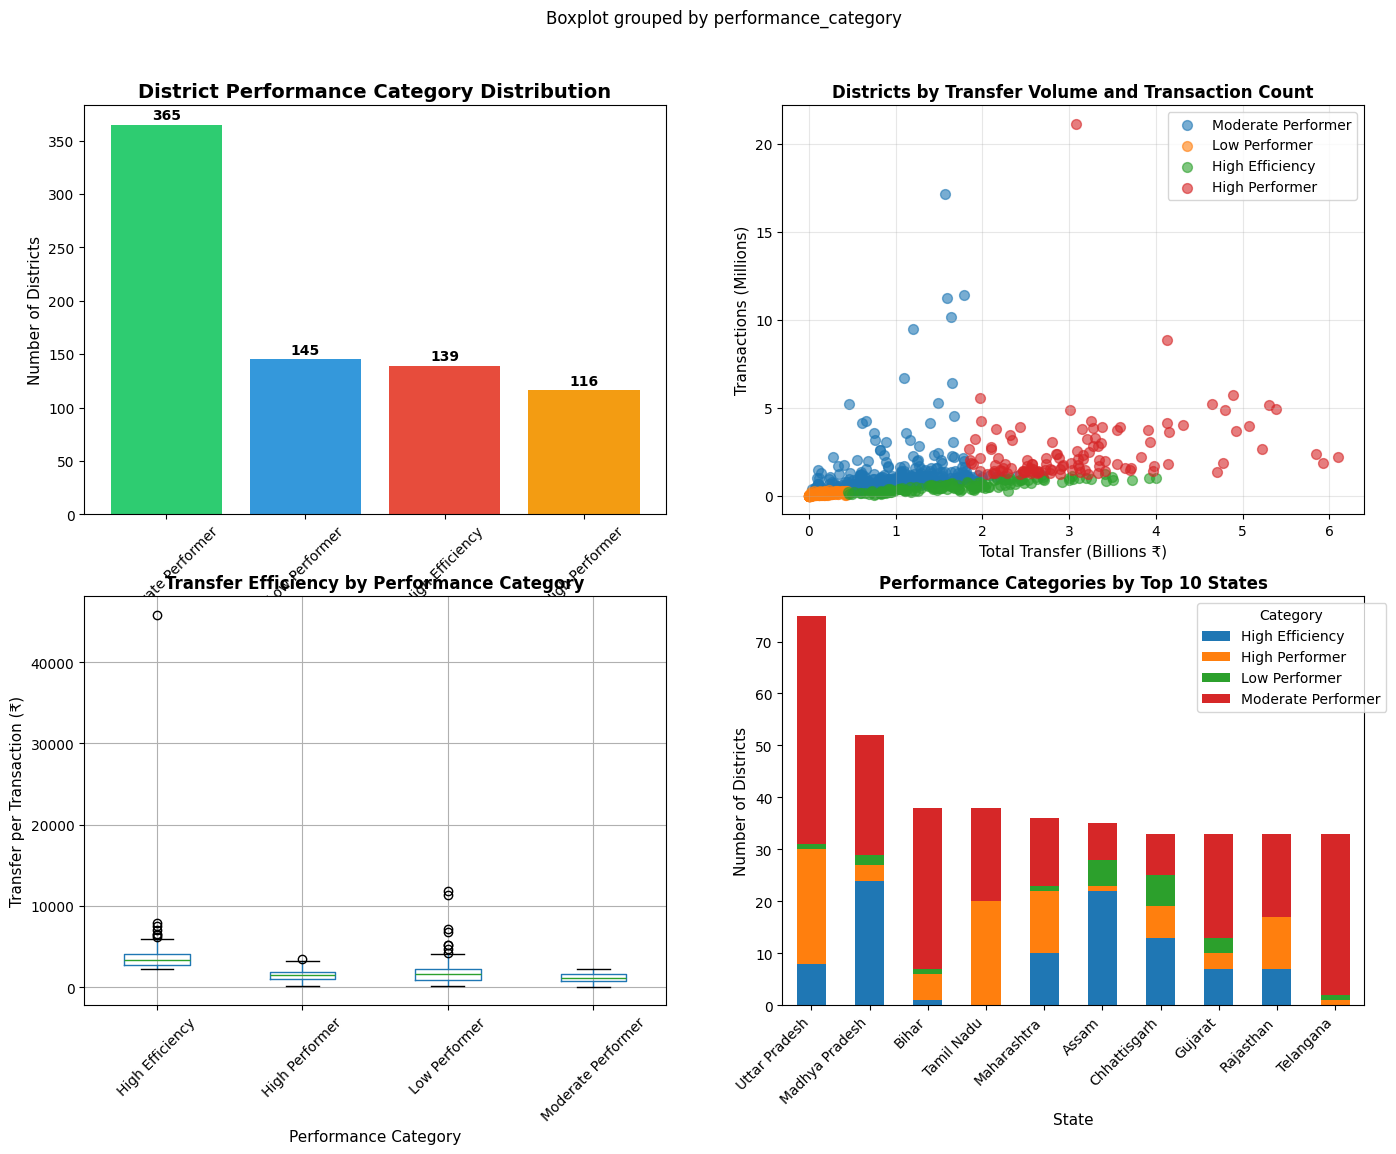

In [ ]:
# ============================================================================
# VISUALIZE TARGET DISTRIBUTION (each plot as a separate figure)
# ============================================================================

# 1. Category Distribution
category_counts = df_2023['performance_category'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(category_counts.index, category_counts.values, color=['#2ecc71', '#3498db', '#e74c3c', '#f39c12'])
plt.title('District Performance Category Distribution (2023-2024)', fontsize=14, fontweight='bold')
plt.ylabel('Number of Districts', fontsize=11)
plt.xticks(rotation=45)
for i, v in enumerate(category_counts.values):
    plt.text(i, v + 5, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

# 2. Scatter: Total Transfer vs Transactions (colored by category)
plt.figure(figsize=(10, 6))
for category in df_2023['performance_category'].unique():
    mask = df_2023['performance_category'] == category
    plt.scatter(df_2023[mask]['total_transfer_billions'], 
                df_2023[mask]['transactions_millions'],
                label=category, alpha=0.7, s=60)
plt.xlabel('Total Transfer (Billions ₹)', fontsize=11)
plt.ylabel('Transactions (Millions)', fontsize=11)
plt.title('Districts by Transfer Volume and Transaction Count (colored by Performance Category)', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Box plot: Transfer per Transaction by Category
plt.figure(figsize=(10, 6))
sns.boxplot(x='performance_category', y='transfer_per_transaction', data=df_2023, palette=['#2ecc71', '#3498db', '#e74c3c', '#f39c12'])
plt.xlabel('Performance Category', fontsize=11)
plt.ylabel('Transfer per Transaction (₹)', fontsize=11)
plt.title('Transfer Efficiency by Performance Category (Transfer per Transaction)', fontsize=13, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. State-wise category distribution (top 10 states) - stacked bar per state
state_category = pd.crosstab(df_2023['state_name'], df_2023['performance_category'])
top_states = state_category.sum(axis=1).nlargest(10).index
plt.figure(figsize=(12, 7))
state_category.loc[top_states].plot(kind='bar', stacked=True)
plt.title('Performance Categories by Top 10 States (Number of Districts)', fontsize=13, fontweight='bold')
plt.xlabel('State', fontsize=11)
plt.ylabel('Number of Districts', fontsize=11)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

In [16]:
# 1. Category Distribution
category_counts = df_2023['performance_category'].value_counts()
axes[0, 0].bar(category_counts.index, category_counts.values, color=['#2ecc71', '#3498db', '#e74c3c', '#f39c12'])
axes[0, 0].set_title('District Performance Category Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Number of Districts', fontsize=11)
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(category_counts.values):
    axes[0, 0].text(i, v + 5, str(v), ha='center', fontweight='bold')

plt.show()

In [6]:
# ============================================================================
# PREPARE DATA FOR CLASSIFICATION
# ============================================================================
print("\n" + "="*80)
print("PREPARING DATA FOR CLASSIFICATION")
print("="*80)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Training class distribution:\n{pd.Series(y_train).value_counts()}")


PREPARING DATA FOR CLASSIFICATION

Training set size: 535
Test set size: 230
Training class distribution:
3    255
2    102
0     97
1     81
Name: count, dtype: int64


In [7]:
# ============================================================================
# MODEL 1: LOGISTIC REGRESSION
# ============================================================================
print("\n" + "="*80)
print("MODEL 1: LOGISTIC REGRESSION")
print("="*80)

# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr')
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_lr_proba = lr_model.predict_proba(X_test_scaled)

# Metrics
print("\nLogistic Regression Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_))

# Cross-validation
cv_scores_lr = cross_val_score(lr_model, X_train_scaled, y_train, cv=5)
print(f"\nCross-validation scores: {cv_scores_lr}")
print(f"Mean CV score: {cv_scores_lr.mean():.4f} (+/- {cv_scores_lr.std() * 2:.4f})")



MODEL 1: LOGISTIC REGRESSION

Logistic Regression Performance:
Accuracy: 0.9391

Classification Report:
                    precision    recall  f1-score   support

   High Efficiency       0.95      0.98      0.96        42
    High Performer       1.00      0.86      0.92        35
     Low Performer       1.00      0.84      0.91        43
Moderate Performer       0.90      0.99      0.94       110

          accuracy                           0.94       230
         macro avg       0.96      0.92      0.94       230
      weighted avg       0.94      0.94      0.94       230


Cross-validation scores: [0.92523364 0.90654206 0.94392523 0.91588785 0.90654206]
Mean CV score: 0.9196 (+/- 0.0280)


In [8]:
# ============================================================================
# MODEL 2: SUPPORT VECTOR MACHINE (SVM)
# ============================================================================
print("\n" + "="*80)
print("MODEL 2: SUPPORT VECTOR MACHINE")
print("="*80)

# Train SVM
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_svm = svm_model.predict(X_test_scaled)
y_pred_svm_proba = svm_model.predict_proba(X_test_scaled)

# Metrics
print("\nSVM Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

# Cross-validation
cv_scores_svm = cross_val_score(svm_model, X_train_scaled, y_train, cv=5)
print(f"\nCross-validation scores: {cv_scores_svm}")
print(f"Mean CV score: {cv_scores_svm.mean():.4f} (+/- {cv_scores_svm.std() * 2:.4f})")


MODEL 2: SUPPORT VECTOR MACHINE

SVM Performance:
Accuracy: 0.9696

Classification Report:
                    precision    recall  f1-score   support

   High Efficiency       1.00      1.00      1.00        42
    High Performer       0.97      0.94      0.96        35
     Low Performer       1.00      0.91      0.95        43
Moderate Performer       0.95      0.99      0.97       110

          accuracy                           0.97       230
         macro avg       0.98      0.96      0.97       230
      weighted avg       0.97      0.97      0.97       230


Cross-validation scores: [0.98130841 0.94392523 0.97196262 0.97196262 0.93457944]
Mean CV score: 0.9607 (+/- 0.0362)


In [9]:
# ============================================================================
# MODEL 3: RANDOM FOREST
# ============================================================================
print("\n" + "="*80)
print("MODEL 3: RANDOM FOREST")
print("="*80)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_rf_proba = rf_model.predict_proba(X_test_scaled)

# Metrics
print("\nRandom Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

# Cross-validation
cv_scores_rf = cross_val_score(rf_model, X_train_scaled, y_train, cv=5)
print(f"\nCross-validation scores: {cv_scores_rf}")
print(f"Mean CV score: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std() * 2:.4f})")

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': features_to_use,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance (Random Forest):")
print(feature_importance)



MODEL 3: RANDOM FOREST

Random Forest Performance:
Accuracy: 1.0000

Classification Report:
                    precision    recall  f1-score   support

   High Efficiency       1.00      1.00      1.00        42
    High Performer       1.00      1.00      1.00        35
     Low Performer       1.00      1.00      1.00        43
Moderate Performer       1.00      1.00      1.00       110

          accuracy                           1.00       230
         macro avg       1.00      1.00      1.00       230
      weighted avg       1.00      1.00      1.00       230


Cross-validation scores: [0.99065421 0.99065421 0.99065421 0.99065421 0.98130841]
Mean CV score: 0.9888 (+/- 0.0075)

Feature Importance (Random Forest):
                    Feature  Importance
0        total_dbt_transfer    0.352957
1    no_of_dbt_transactions    0.350523
2  transfer_per_transaction    0.296520


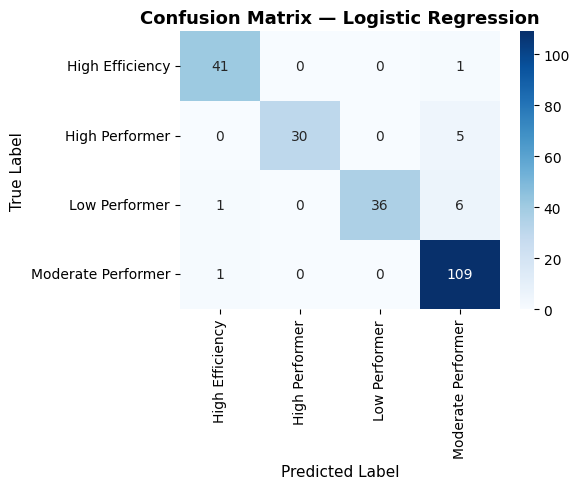

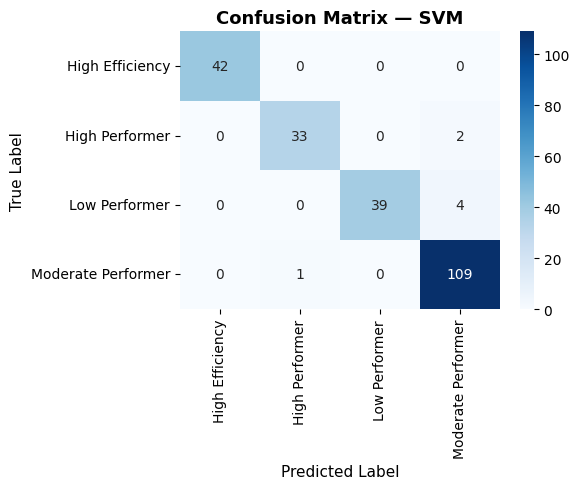

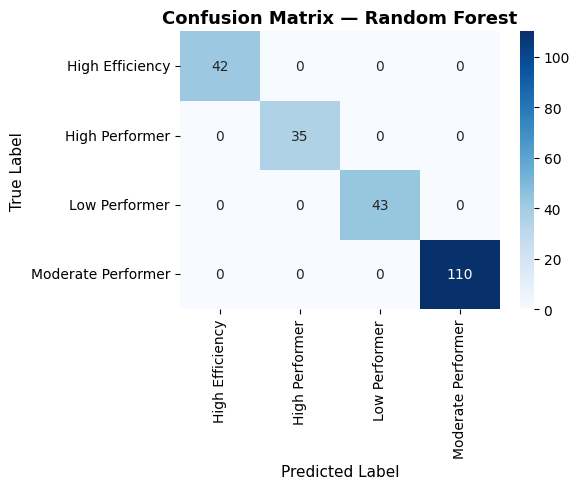

In [17]:
# ============================================================================
# CONFUSION MATRICES VISUALIZATION (each as an individual figure)
# ============================================================================

models = [
    ('Logistic Regression', y_pred_lr),
    ('SVM', y_pred_svm),
    ('Random Forest', y_pred_rf)
]

for name, y_pred in models:
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix — {name}', fontsize=13, fontweight='bold')
    plt.ylabel('True Label', fontsize=11)
    plt.xlabel('Predicted Label', fontsize=11)
    plt.tight_layout()
    plt.show()

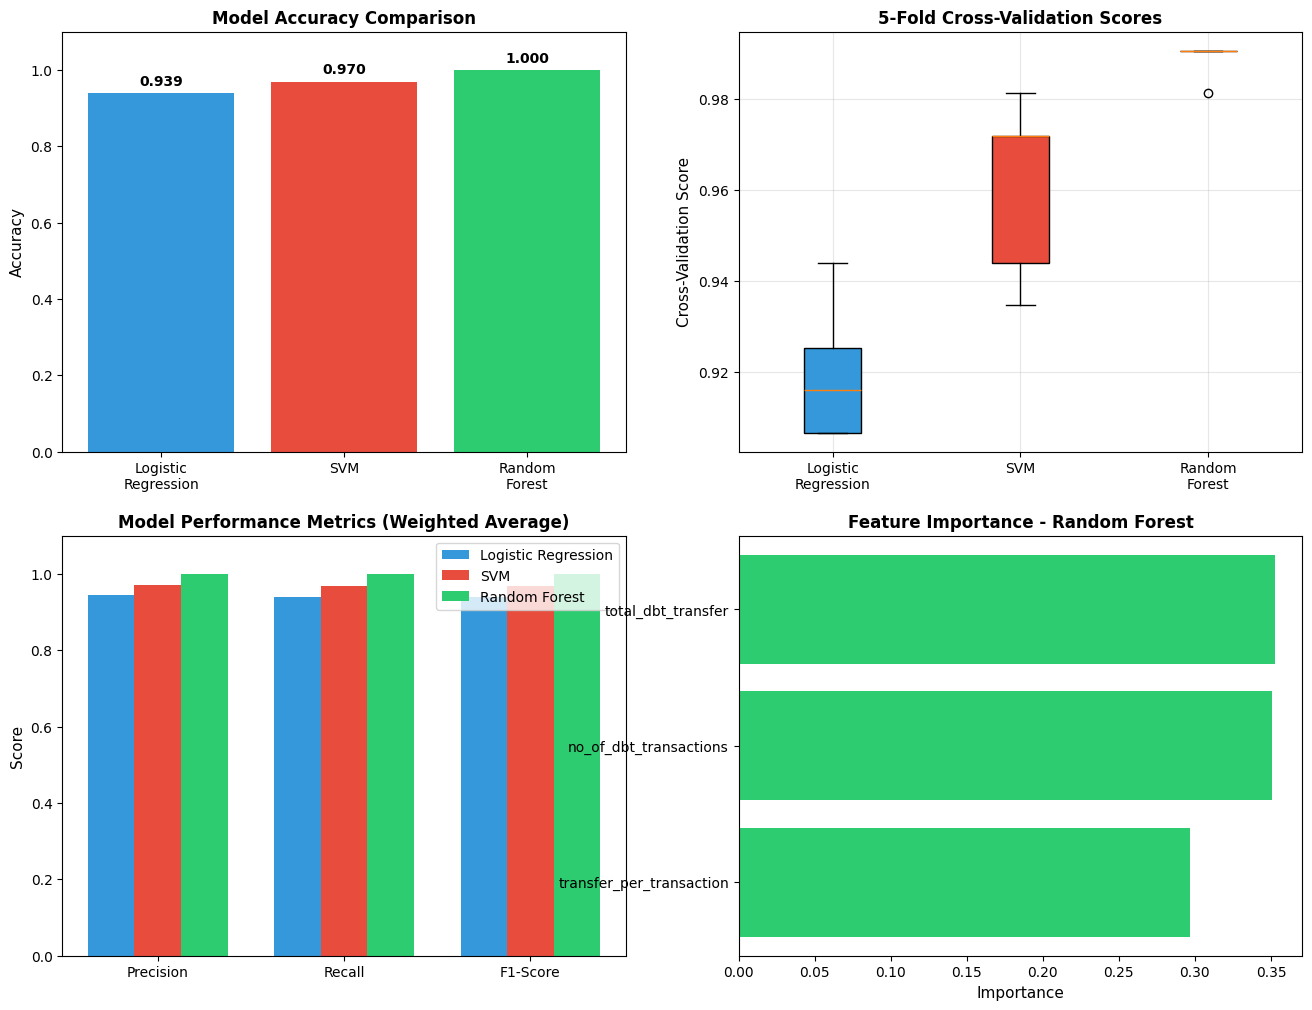

In [ ]:
# ============================================================================
# MODEL COMPARISON VISUALIZATION (each plot as a separate figure)
# ============================================================================

# 1. Accuracy Comparison
models_names = ['Logistic\nRegression', 'SVM', 'Random\nForest']
accuracies = [
    accuracy_score(y_test, y_pred_lr),
    accuracy_score(y_test, y_pred_svm),
    accuracy_score(y_test, y_pred_rf)
]
plt.figure(figsize=(8, 6))
plt.bar(models_names, accuracies, color=['#3498db', '#e74c3c', '#2ecc71'])
plt.ylabel('Accuracy', fontsize=11)
plt.title('Model Accuracy Comparison (Test Set)', fontsize=13, fontweight='bold')
plt.ylim(0, 1.05)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

# 2. Cross-validation Scores (boxplots per model)
cv_data = [cv_scores_lr, cv_scores_svm, cv_scores_rf]
plt.figure(figsize=(8, 6))
bp = plt.boxplot(cv_data, labels=['Logistic\nRegression', 'SVM', 'Random\nForest'], patch_artist=True)
colors = ['#3498db', '#e74c3c', '#2ecc71']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
plt.ylabel('5-Fold CV Score', fontsize=11)
plt.title('Cross-Validation Score Distribution (5-Fold)', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Precision, Recall, F1-Score Comparison (grouped bar chart)
metrics_lr = precision_recall_fscore_support(y_test, y_pred_lr, average='weighted')
metrics_svm = precision_recall_fscore_support(y_test, y_pred_svm, average='weighted')
metrics_rf = precision_recall_fscore_support(y_test, y_pred_rf, average='weighted')

metrics_names = ['Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics_names))
width = 0.25
plt.figure(figsize=(8, 6))
plt.bar(x - width, metrics_lr[:3], width, label='Logistic Regression', color='#3498db')
plt.bar(x, metrics_svm[:3], width, label='SVM', color='#e74c3c')
plt.bar(x + width, metrics_rf[:3], width, label='Random Forest', color='#2ecc71')
plt.ylabel('Score', fontsize=11)
plt.title('Model Performance Metrics (Weighted Average) — Precision / Recall / F1', fontsize=13, fontweight='bold')
plt.xticks(x, metrics_names)
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.show()

# 4. Feature Importance (Random Forest) — single horizontal bar chart
plt.figure(figsize=(8, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='#2ecc71')
plt.xlabel('Importance', fontsize=11)
plt.title('Feature Importance — Random Forest', fontsize=13, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

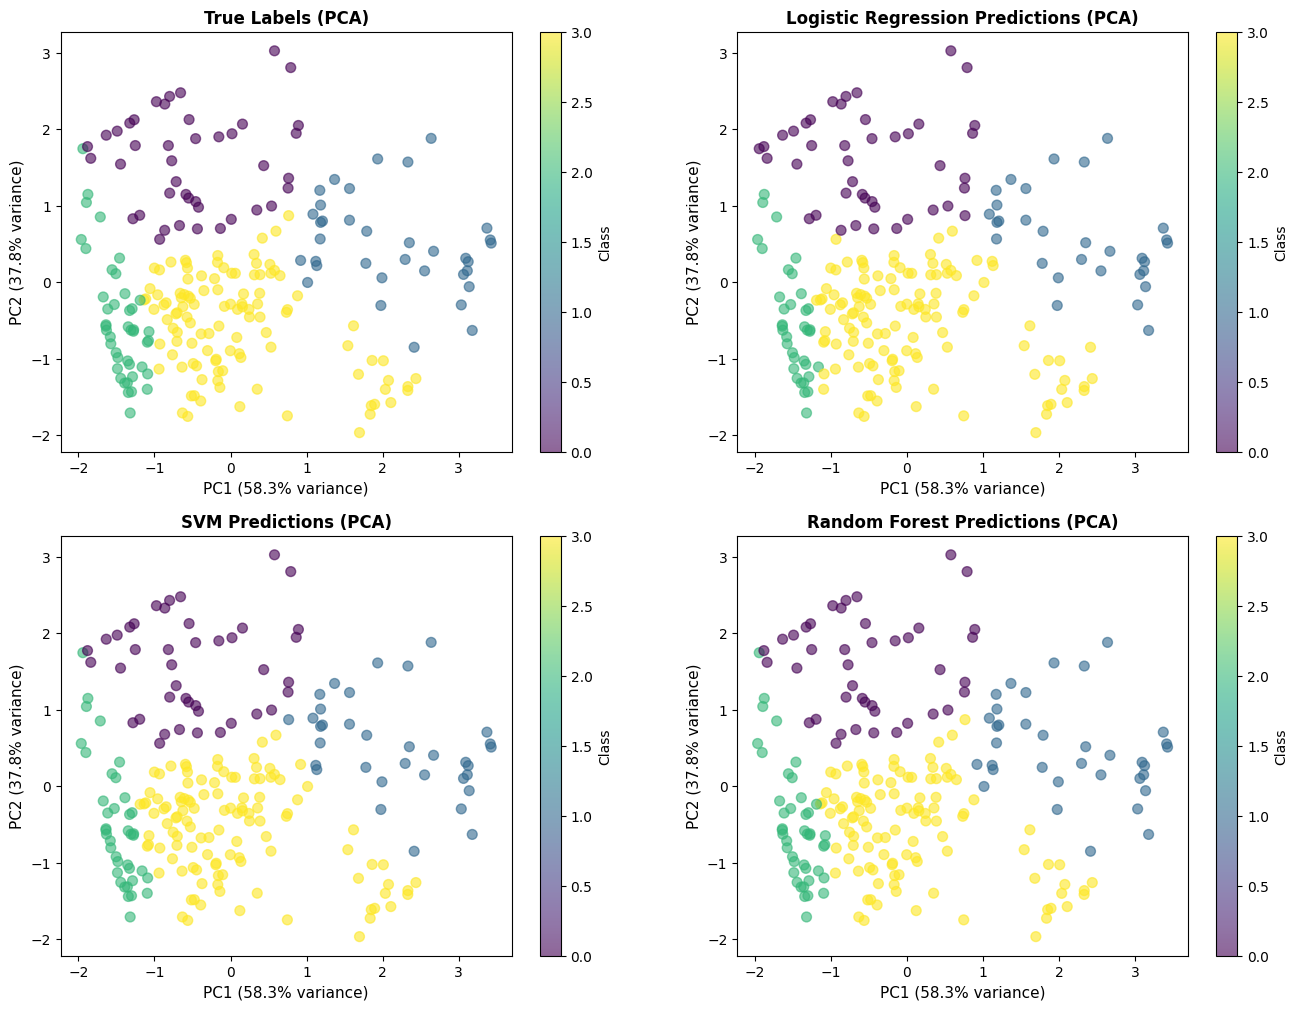

In [ ]:
# ============================================================================
# PCA VISUALIZATION WITH PREDICTIONS (each scatter as separate figure)
# ============================================================================
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test_scaled)

# 1. True labels
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='viridis', alpha=0.6, s=50)
plt.title('PCA: True Labels (2 Principal Components)', fontsize=13, fontweight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.colorbar(scatter, label='Class')
plt.tight_layout()
plt.show()

# 2. Logistic Regression predictions
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred_lr, cmap='viridis', alpha=0.6, s=50)
plt.title('PCA: Logistic Regression Predictions (2 PCs)', fontsize=13, fontweight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.colorbar(scatter, label='Predicted Class')
plt.tight_layout()
plt.show()

# 3. SVM predictions
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred_svm, cmap='viridis', alpha=0.6, s=50)
plt.title('PCA: SVM Predictions (2 PCs)', fontsize=13, fontweight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.colorbar(scatter, label='Predicted Class')
plt.tight_layout()
plt.show()

# 4. Random Forest predictions
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred_rf, cmap='viridis', alpha=0.6, s=50)
plt.title('PCA: Random Forest Predictions (2 PCs)', fontsize=13, fontweight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.colorbar(scatter, label='Predicted Class')
plt.tight_layout()
plt.show()

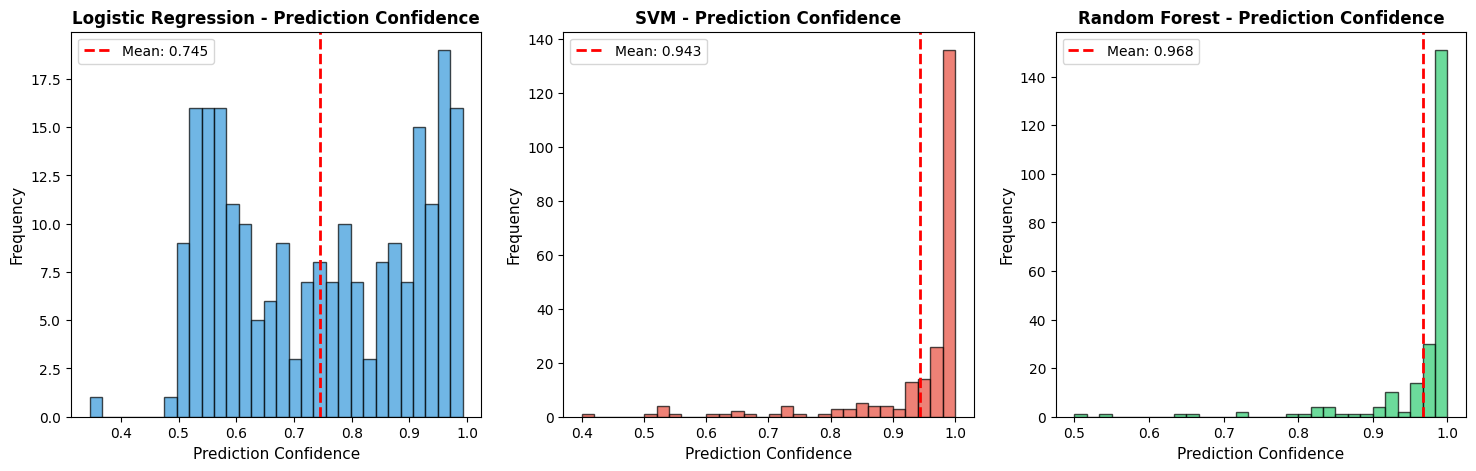

In [ ]:
# ============================================================================
# PREDICTION CONFIDENCE ANALYSIS (each histogram as separate figure)
# ============================================================================

# Confidence scores for each model
confidence_lr = np.max(y_pred_lr_proba, axis=1)
confidence_svm = np.max(y_pred_svm_proba, axis=1)
confidence_rf = np.max(y_pred_rf_proba, axis=1)

# Logistic Regression confidence
plt.figure(figsize=(8, 5))
plt.hist(confidence_lr, bins=30, alpha=0.8, color='#3498db', edgecolor='black')
plt.xlabel('Prediction Confidence', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Logistic Regression — Prediction Confidence Distribution', fontsize=13, fontweight='bold')
plt.axvline(confidence_lr.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {confidence_lr.mean():.3f}')
plt.legend()
plt.tight_layout()
plt.show()

# SVM confidence
plt.figure(figsize=(8, 5))
plt.hist(confidence_svm, bins=30, alpha=0.8, color='#e74c3c', edgecolor='black')
plt.xlabel('Prediction Confidence', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('SVM — Prediction Confidence Distribution', fontsize=13, fontweight='bold')
plt.axvline(confidence_svm.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {confidence_svm.mean():.3f}')
plt.legend()
plt.tight_layout()
plt.show()

# Random Forest confidence
plt.figure(figsize=(8, 5))
plt.hist(confidence_rf, bins=30, alpha=0.8, color='#2ecc71', edgecolor='black')
plt.xlabel('Prediction Confidence', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Random Forest — Prediction Confidence Distribution', fontsize=13, fontweight='bold')
plt.axvline(confidence_rf.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {confidence_rf.mean():.3f}')
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*80)
print("CLASSIFICATION SUMMARY")
print("="*80)

summary_data = {
    'Model': ['Logistic Regression', 'SVM', 'Random Forest'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_svm),
        accuracy_score(y_test, y_pred_rf)
    ],
    'Mean CV Score': [
        cv_scores_lr.mean(),
        cv_scores_svm.mean(),
        cv_scores_rf.mean()
    ],
    'CV Std': [
        cv_scores_lr.std(),
        cv_scores_svm.std(),
        cv_scores_rf.std()
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n", summary_df.to_string(index=False))

best_model_idx = summary_df['Accuracy'].idxmax()
print(f"\nBest performing model: {summary_df.iloc[best_model_idx]['Model']}")
print(f"with accuracy: {summary_df.iloc[best_model_idx]['Accuracy']:.4f}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)


CLASSIFICATION SUMMARY

               Model  Accuracy  Mean CV Score   CV Std
Logistic Regression  0.939130       0.919626 0.013988
                SVM  0.969565       0.960748 0.018122
      Random Forest  1.000000       0.988785 0.003738

Best performing model: Random Forest
with accuracy: 1.0000

ANALYSIS COMPLETE
